## Import Packages and image sets

In [1]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import glob
import os

import torch
#import torchvision
#import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as D
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import measure, filters
from sklearn.preprocessing import OneHotEncoder
print(torch.__version__)
import time

save_name = '/home/jay/data/BNL_032020/BNL_032020_900_1/pytorchtest/singlelayer8_7x7batch128_short_blur3_sigmoid_lr0001'

1.4.0


In [2]:
images = np.load('training_set.npy',mmap_mode='r+')[:10000].reshape(-1,1,512,512)
#images_blur = np.zeros_like(images)
images.shape

def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im))

def scale(im):
    return (im - np.mean(im)) / np.std(im)

for i in range(len(images)):
    if i %1000 == 0:
        print(i)
    images[i] = norm(scale(filters.gaussian(images[i],sigma=3)))


#for i in range(len(images)):
#    images[i] = norm(images[i])
#    
#print(images.shape)
#for i in range(len(images)):
#    if i % 1000 == 0:
#        print(i)
#    images_blur[i] = filters.gaussian(images[i],2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [3]:
tensor_im = torch.stack([torch.Tensor(i) for i in images])
#tensor_lab = torch.stack([torch.Tensor(i) for i in train_maps])

dataset = torch.utils.data.TensorDataset(tensor_im)
#dataset = torch.utils.data.TensorDataset(tensor_im,tensor_lab)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

## Initialize CNN Architectures

### Modified for Autoencoder

In [4]:
### Not a UNet -- no skip connections

class autoencoder_base(nn.Module):
    def __init__(self):
        super(autoencoder_base,self).__init__()
        self.conv0 = nn.Conv2d(1,8,3,dilation=1,padding=1)
        self.b0 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(8,16,3,dilation=1,padding=1)
        self.b1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3,dilation=1,padding=1)
        self.b2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3,dilation=1,padding=1)
        self.b3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64,32,3,stride=2,padding=(1,1))
        self.b4 = nn.BatchNorm2d(32)
        self.conv4_1 = nn.Conv2d(96,96,3,padding=1)
        self.b4_1 = nn.BatchNorm2d(96)
        self.conv5 = nn.ConvTranspose2d(32,16,3,stride=2,padding=(1,1))
        self.b5 = nn.BatchNorm2d(16)
        self.conv5_1 = nn.Conv2d(64,64,3,padding=1)
        self.b5_1 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(16,8,3,stride=2,padding=(1,1))
        self.b6 = nn.BatchNorm2d(8)
        self.conv6_1 = nn.Conv2d(32,32,3,padding=1)
        self.b6_1 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(8,1,3,stride=2,padding=(1,1))
        self.b7 = nn.BatchNorm2d(1)
        self.conv7_1 = nn.Conv2d(24,24,3,padding=1)
        self.b7_1 = nn.BatchNorm2d(24)
        self.conv8 = nn.Conv2d(24,8,3,padding=(1,1))
        self.b8 = nn.BatchNorm2d(8)
        self.conv8_1 = nn.Conv2d(8,8,3,padding=1)
        self.b8_1 = nn.BatchNorm2d(8)
        self.conv9 = nn.Conv2d(8,2,1)
        self.b9 = nn.BatchNorm2d(2)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        c2 = self.pool(self.b2(F.relu(self.conv2(c1))))
        c3 = self.pool(self.b3(F.relu(self.conv3(c2))))
        c4 = self.b4(F.relu(self.conv4(c3,output_size=c2.size())))
        c5 = self.b5(F.relu(self.conv5(c4,output_size=c1.size())))
        c6 = self.b6(F.relu(self.conv6(c5,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7
    
class autoencoder_bottle(nn.Module):
    def __init__(self):
        super(autoencoder_bottle,self).__init__()
        self.conv0 = nn.Conv2d(1,2,3,dilation=1,padding=1)
        self.b0 = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2,8,3,dilation=1,padding=1)
        self.b1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,3,dilation=1,padding=1)
        self.b2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,10,3,dilation=1,padding=1)
        self.b3 = nn.BatchNorm2d(10)
        self.conv4 = nn.ConvTranspose2d(10,16,3,stride=2,padding=(1,1))
        self.b4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16,8,3,stride=2,padding=(1,1))
        self.b5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8,2,3,stride=2,padding=(1,1))
        self.b6 = nn.BatchNorm2d(2)
        self.conv7 = nn.ConvTranspose2d(2,1,3,stride=2,padding=(1,1))
        self.b7 = nn.BatchNorm2d(1)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        c2 = self.pool(self.b2(F.relu(self.conv2(c1))))
        c3 = self.pool(self.b3(F.relu(self.conv3(c2))))
        c4 = self.b4(F.relu(self.conv4(c3,output_size=c2.size())))
        c5 = self.b5(F.relu(self.conv5(c4,output_size=c1.size())))
        c6 = self.b6(F.relu(self.conv6(c5,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7
    
    
class autoencoder_bottle_large(nn.Module):
    def __init__(self):
        super(autoencoder_bottle_large,self).__init__()
        self.conv0 = nn.Conv2d(1,2,7,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2,8,7,dilation=1,padding=3)
        self.b1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,7,dilation=1,padding=3)
        self.b2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,2,7,dilation=1,padding=3)
        self.b3 = nn.BatchNorm2d(2)
        self.conv4 = nn.ConvTranspose2d(2,16,7,stride=2,padding=3)
        self.b4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16,8,7,stride=2,padding=3)
        self.b5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8,2,7,stride=2,padding=3)
        self.b6 = nn.BatchNorm2d(2)
        self.conv7 = nn.ConvTranspose2d(2,1,7,stride=2,padding=3)
        self.b7 = nn.BatchNorm2d(1)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        c2 = self.pool(self.b2(F.relu(self.conv2(c1))))
        c3 = self.pool(self.b3(F.relu(self.conv3(c2))))
        c4 = self.b4(F.relu(self.conv4(c3,output_size=c2.size())))
        c5 = self.b5(F.relu(self.conv5(c4,output_size=c1.size())))
        c6 = self.b6(F.relu(self.conv6(c5,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7
    
    
class autoencoder_bottle_large_shallow(nn.Module):
    def __init__(self):
        super(autoencoder_bottle_large_shallow,self).__init__()
        self.conv0 = nn.Conv2d(1,2,7,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2,8,7,dilation=1,padding=3)
        self.b1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,7,dilation=1,padding=3)
        self.b2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,2,7,dilation=1,padding=3)
        self.b3 = nn.BatchNorm2d(2)
        self.conv4 = nn.ConvTranspose2d(2,16,7,stride=2,padding=3)
        self.b4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16,8,7,stride=2,padding=3)
        self.b5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8,2,7,stride=2,padding=3)
        self.b6 = nn.BatchNorm2d(2)
        self.conv7 = nn.ConvTranspose2d(2,1,7,stride=2,padding=3)
        self.b7 = nn.BatchNorm2d(1)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        #c2 = self.pool(self.b2(F.relu(self.conv2(c1))))
        #c3 = self.pool(self.b3(F.relu(self.conv3(c2))))
        #c4 = self.b4(F.relu(self.conv4(c3,output_size=c2.size())))
        #c5 = self.b5(F.relu(self.conv5(c4,output_size=c1.size())))
        c6 = self.b6(F.relu(self.conv6(c1,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7

class single_layer(nn.Module):
    def __init__(self):
        super(single_layer,self).__init__()
        self.conv0 = nn.Conv2d(1,2,7,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(2)
        
#        self.conv1 = nn.ConvTranspose2d(8,2,7,stride=2,padding=3)
#        self.b1 = nn.BatchNorm2d(2)
#
#        self.conv2 = nn.Conv2d(2,8,7,dilation=1,padding=3)
#        self.b2 = nn.BatchNorm2d(8)
        
        self.conv3 = nn.Conv2d(2,1,7,dilation=1,padding=3)
        self.b3 = nn.BatchNorm2d(1)
        
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
#        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
#        c1 = self.b1(F.relu(self.conv1(c0,output_size=x.size())))
#        c2 = self.b2(F.relu(self.conv2(c1)))
#        c3 = self.b3(F.relu(self.conv3(c2)))
#        c1 = F.softmax(c1,dim=0)
        c0 = self.b0(F.relu(self.conv0(x)))
        c1 = self.b3(F.relu(self.conv3(c0)))
        #return c1
        return torch.sigmoid(c1)

model = single_layer()

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),lr = 0.0001) 

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[30])


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
### Use the following line only if training on multiple GPUs
model = nn.DataParallel(model)

### Use following section only if continuing training from a checkpoint
#checkpoint = torch.load('/home/jay/data/BNL_032020/pytorchtest/singlelayer8_3x3batch128_short_softmax_e19.pt')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
#for state in optimizer.state.values():
#    for k,v in state.items():
#        if isinstance(v,torch.Tensor):
#            state[k] = v.to(device)
#
#### Change following line to model.eval() for inference
#model.eval()


cuda:0


In [ ]:
print(np.min(images),np.max(images))

## Training routine

Epoch 1
0%
loss: 0.049054662213672565
Epoch time: 20.563669681549072

Epoch 2
0%
loss: 0.04384284268451642
Epoch time: 15.12261962890625

Epoch 3
0%
loss: 0.04121677115370956
Epoch time: 15.161603450775146

Epoch 4
0%
loss: 0.03945725231985502
Epoch time: 15.20847773551941

Epoch 5
0%
loss: 0.03572335959518257
Epoch time: 15.508256435394287

Epoch 6
0%
loss: 0.029926146675325647
Epoch time: 15.259655952453613

Epoch 7
0%
loss: 0.02729409782192375
Epoch time: 15.261007308959961

Epoch 8
0%
loss: 0.026006154197303556
Epoch time: 15.27859616279602

Epoch 9
0%
loss: 0.024732466574899758
Epoch time: 15.306761026382446

Epoch 10
0%
loss: 0.02395489281397077
Epoch time: 15.541796207427979

Epoch 11
0%
loss: 0.023061165704002864
Epoch time: 15.311224222183228

Epoch 12
0%
loss: 0.021992299469965924
Epoch time: 15.304343461990356

Epoch 13
0%
loss: 0.02116344258472135
Epoch time: 15.286662340164185

Epoch 14
0%
loss: 0.020562429877021646
Epoch time: 15.308722257614136

Epoch 15
0%
loss: 0.01976

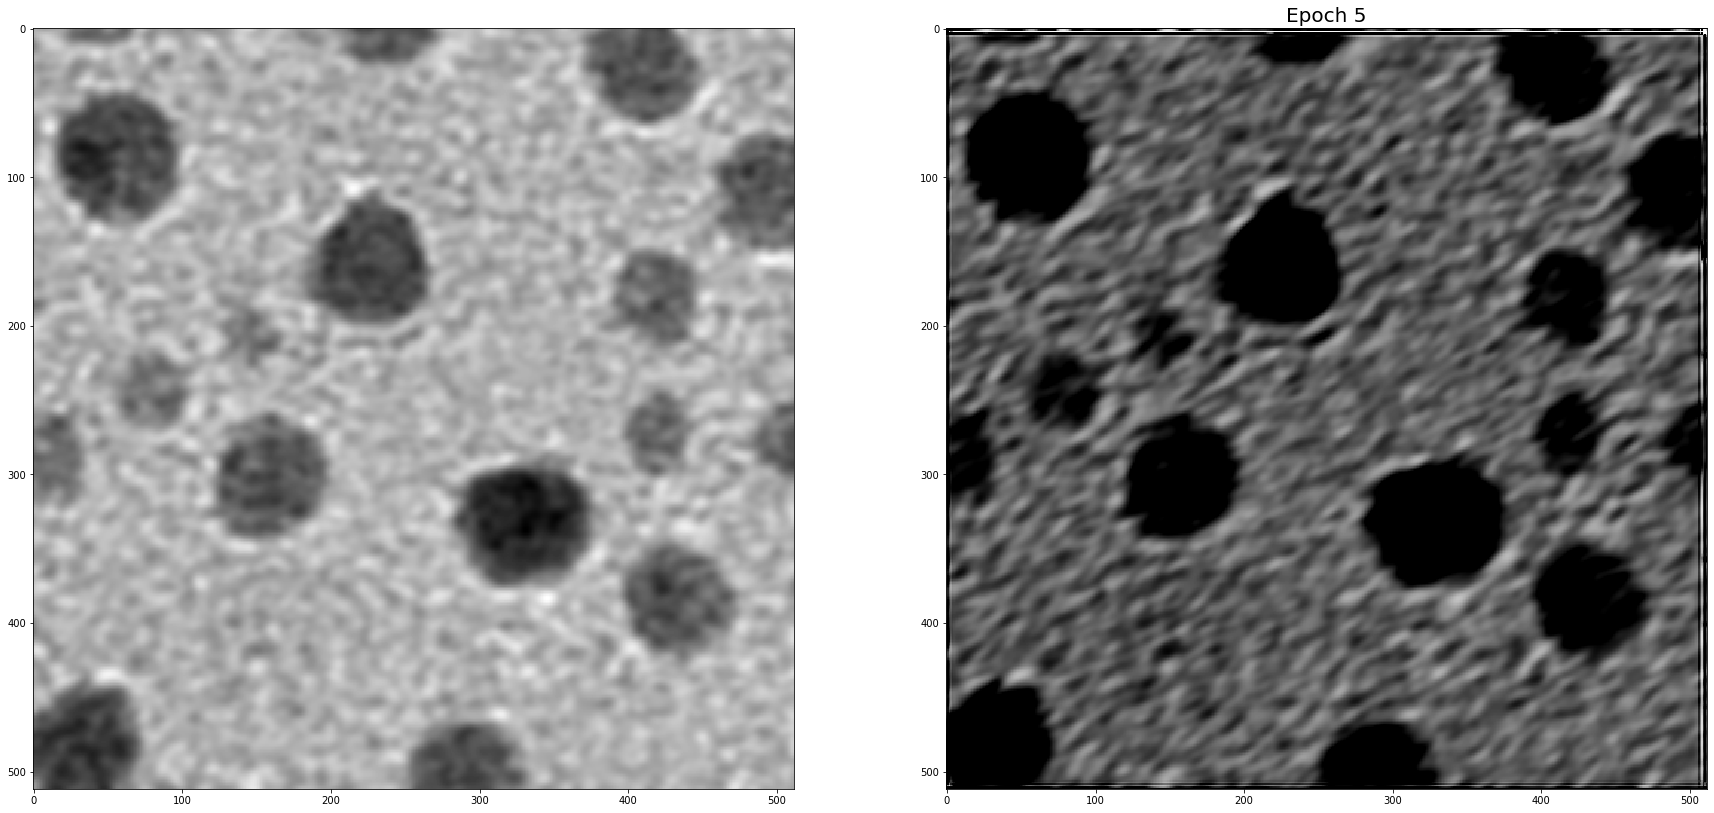

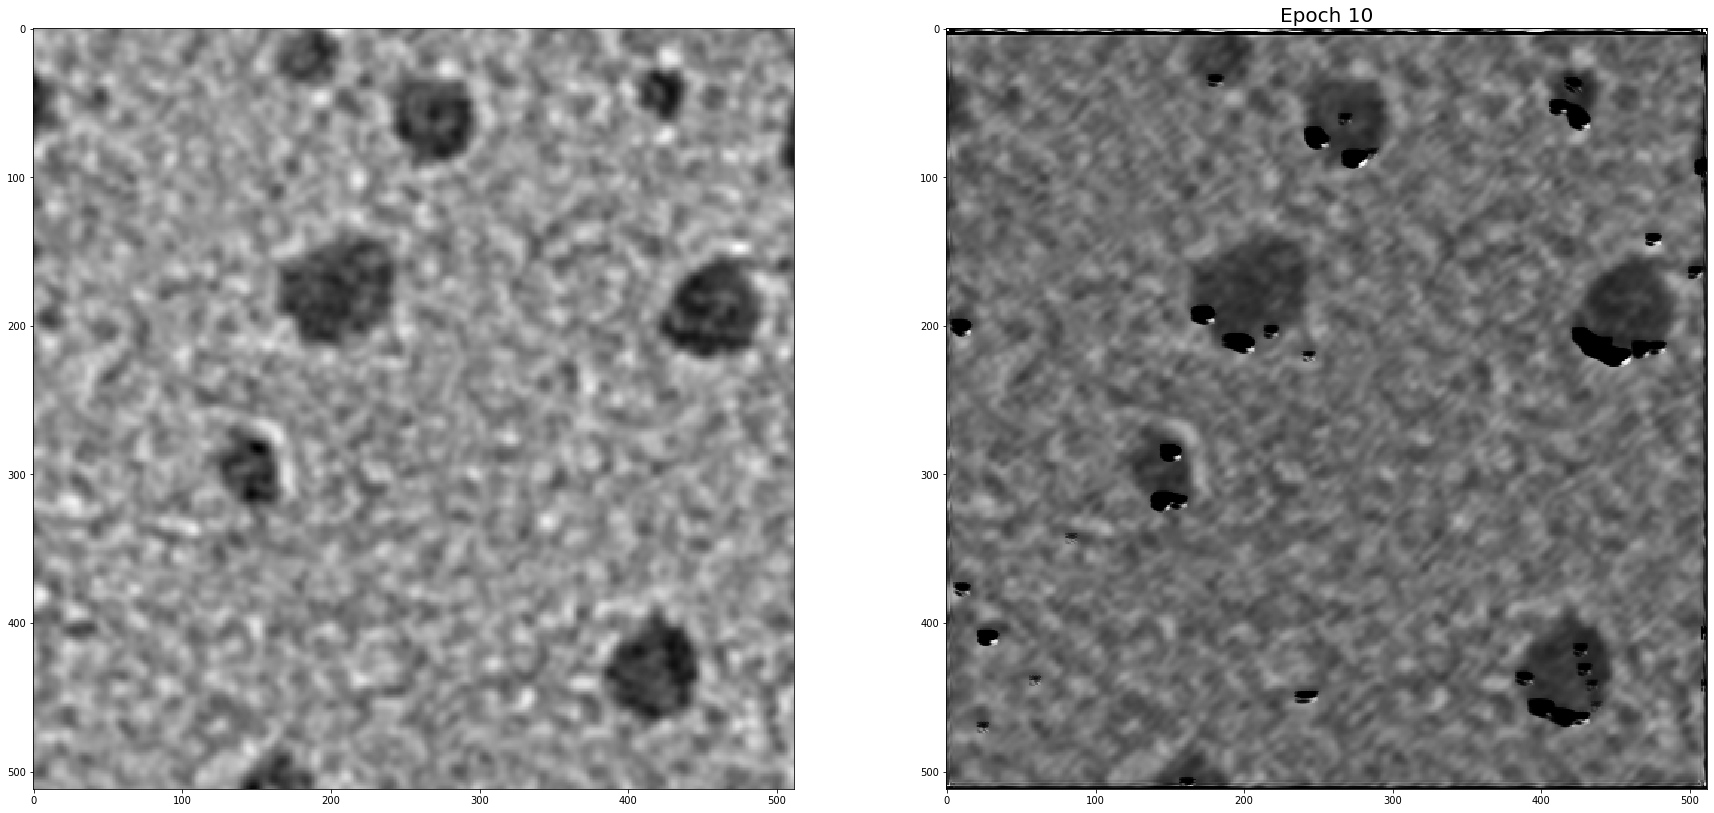

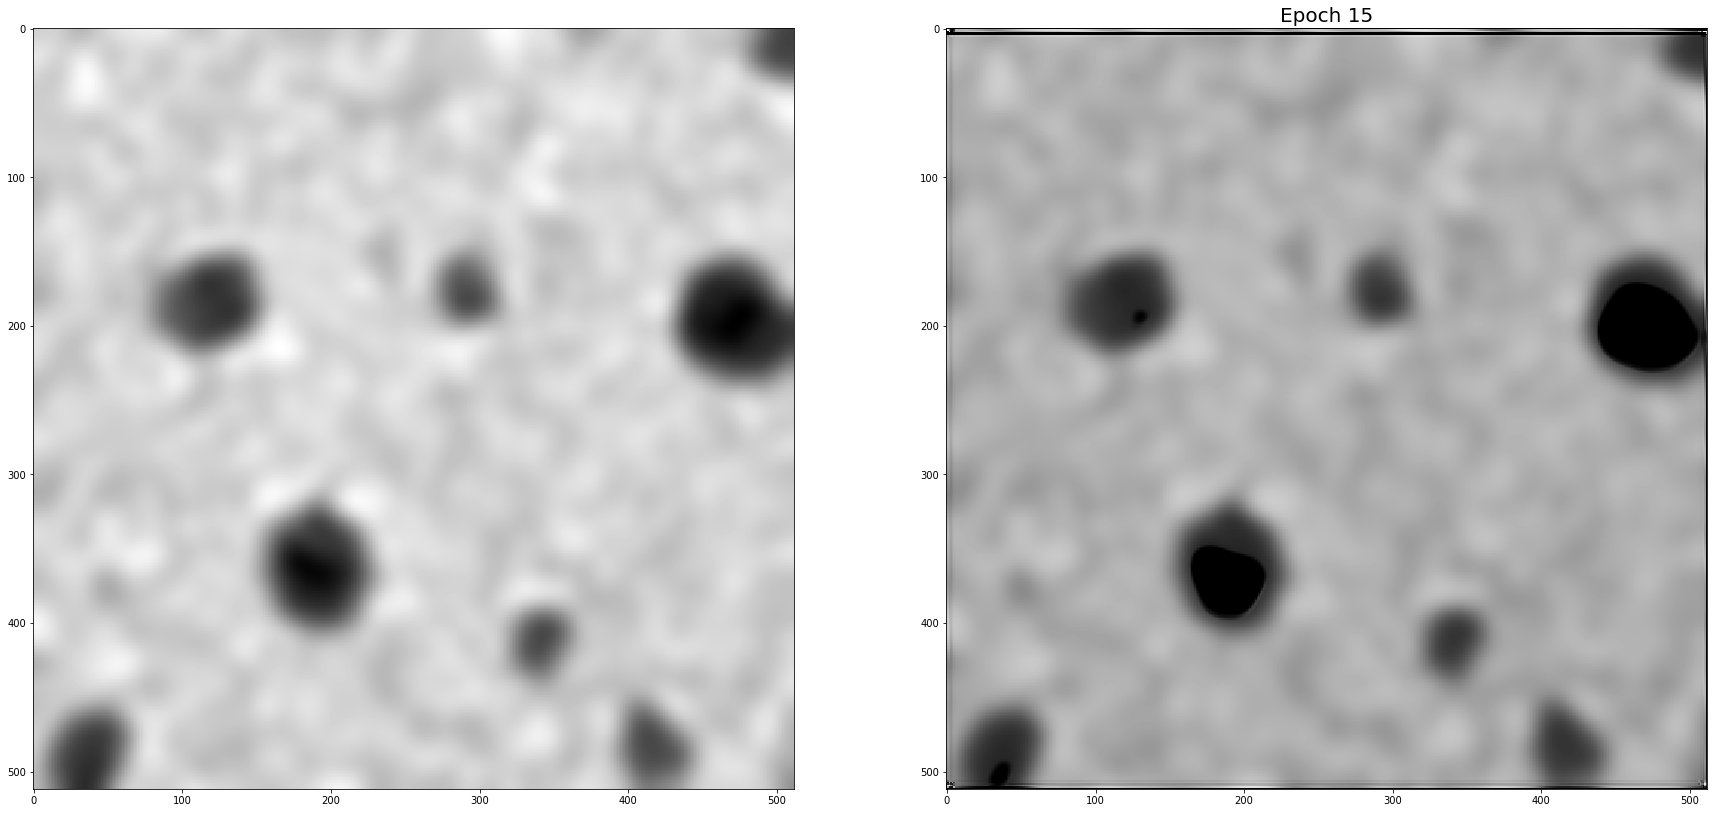

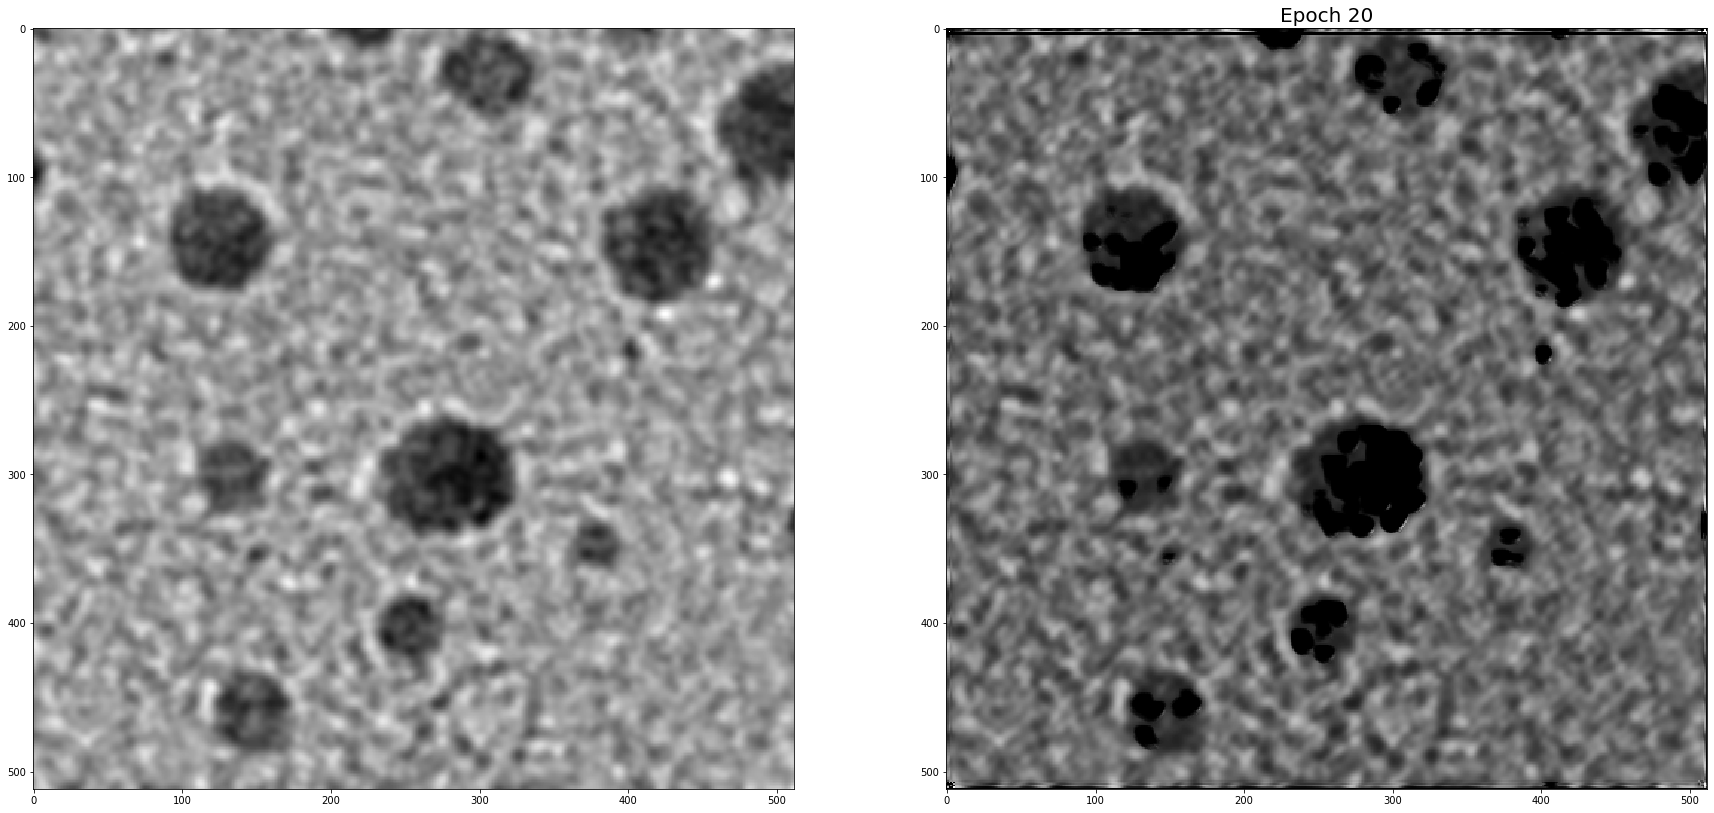

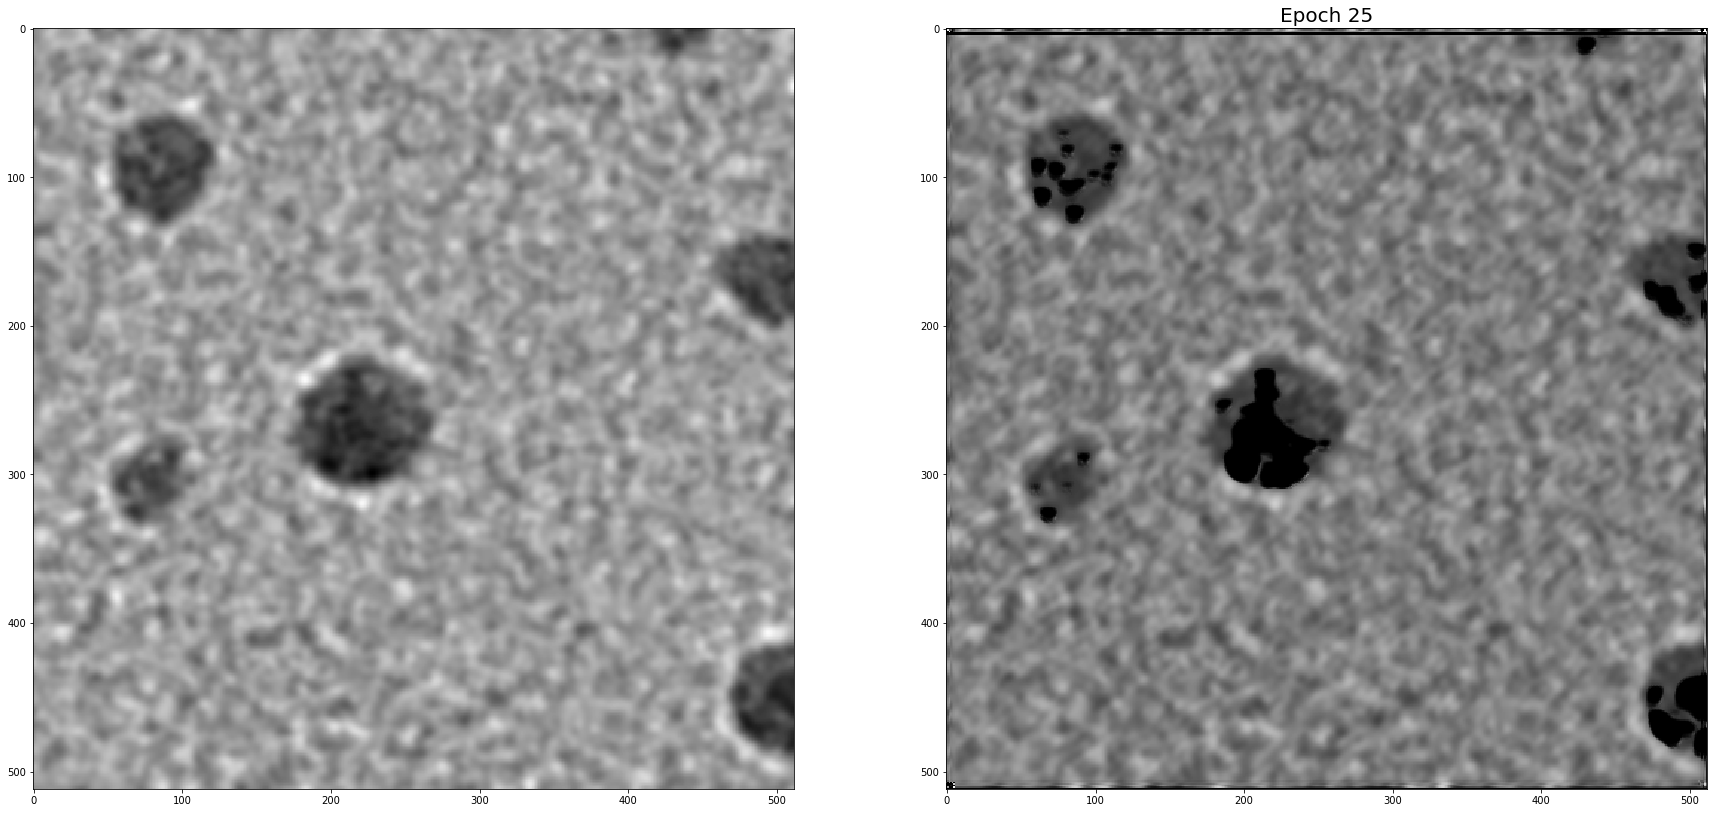

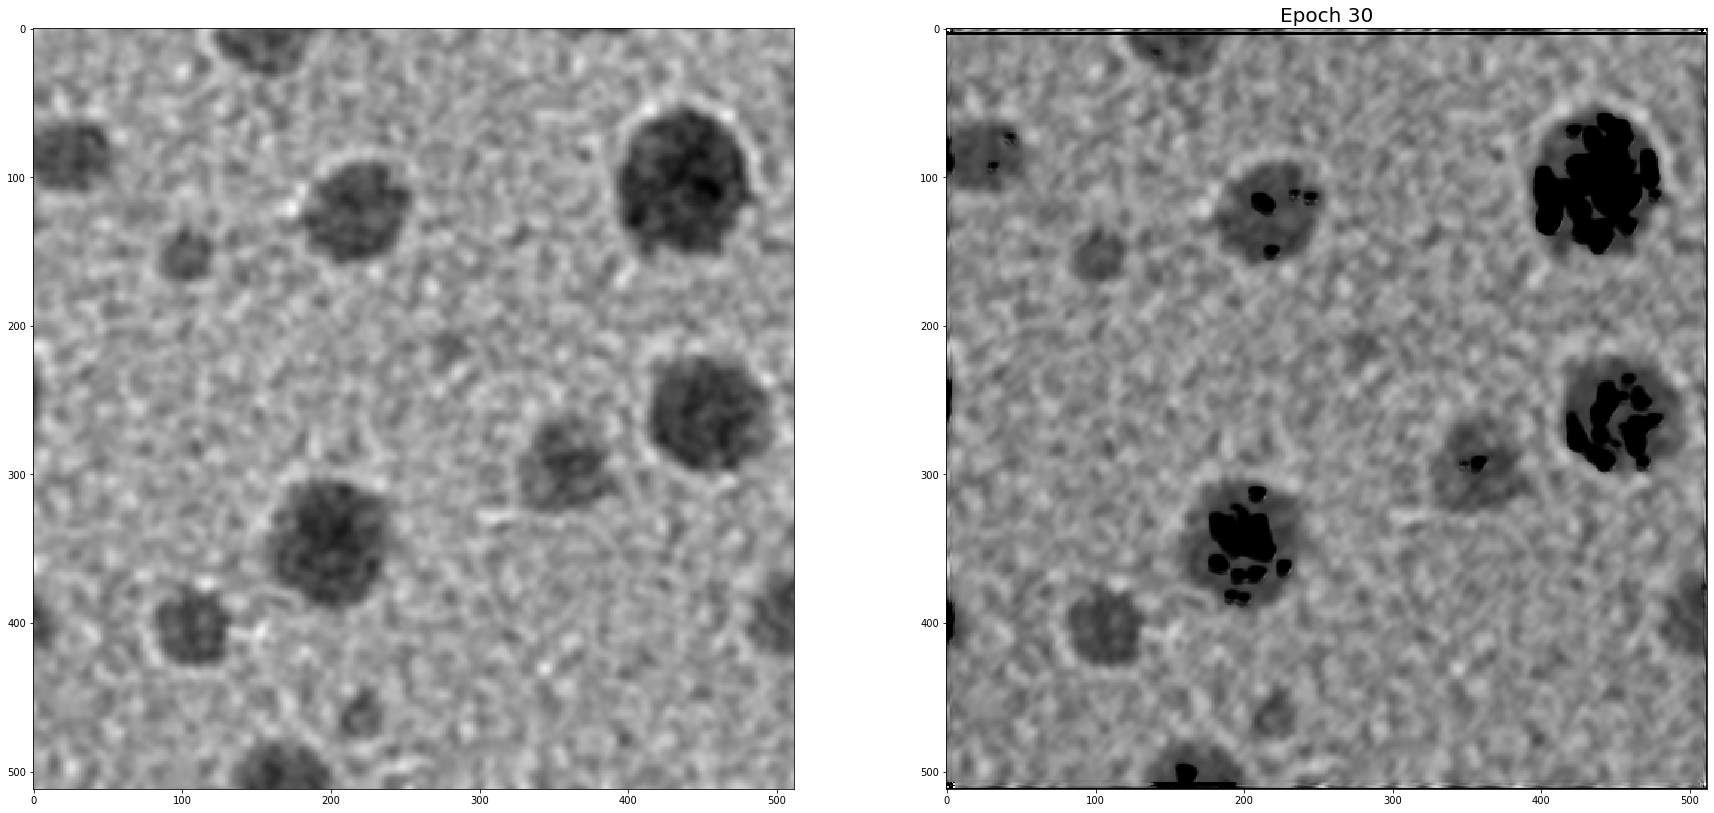

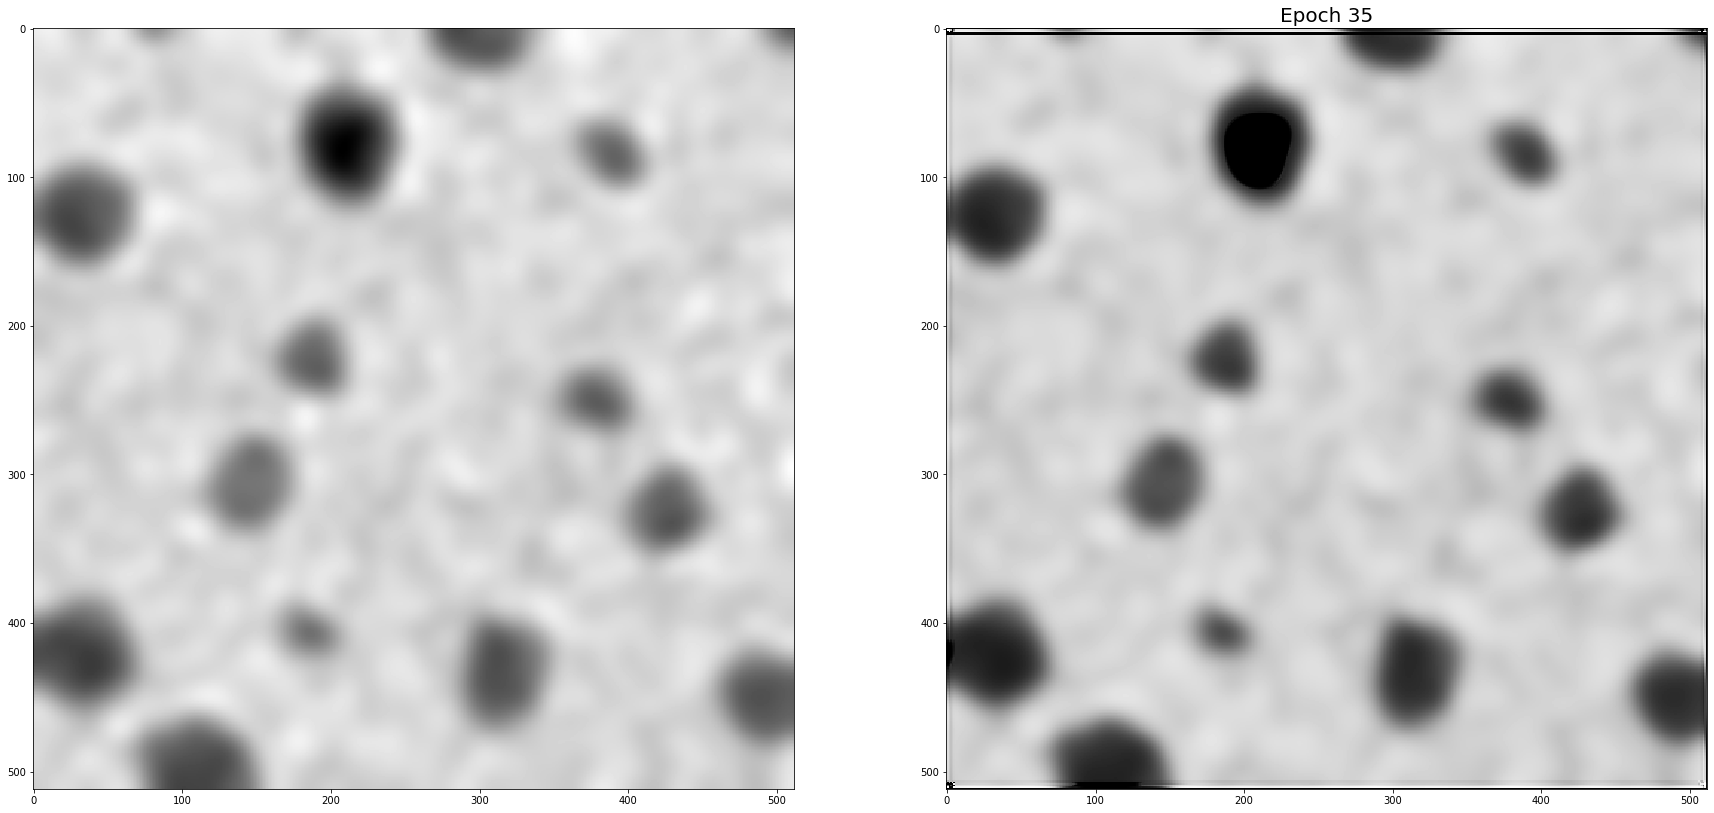

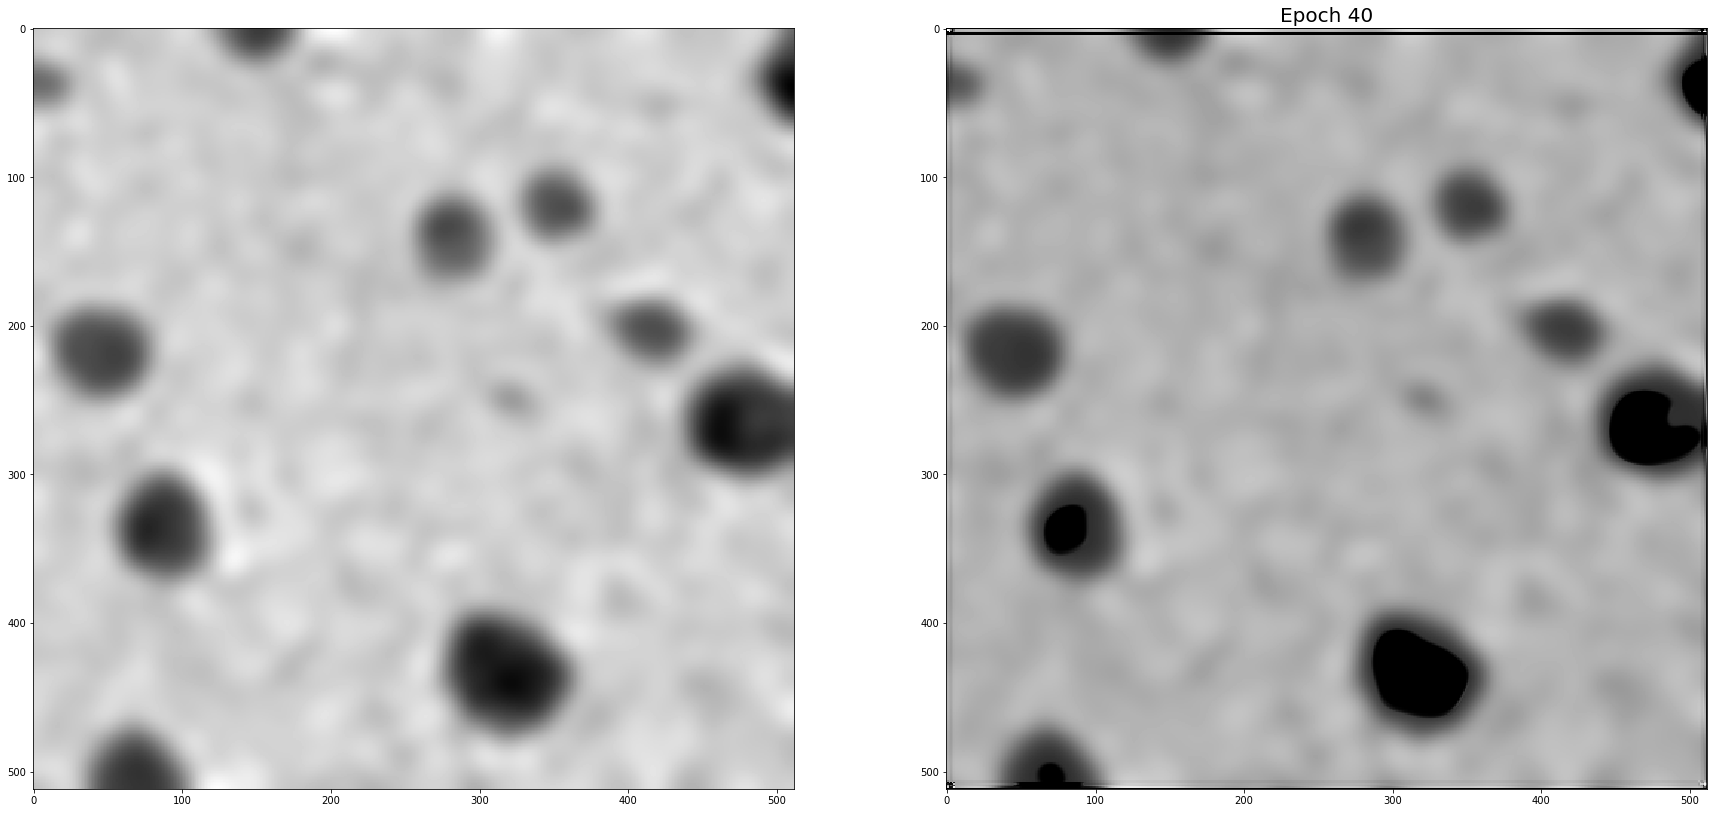

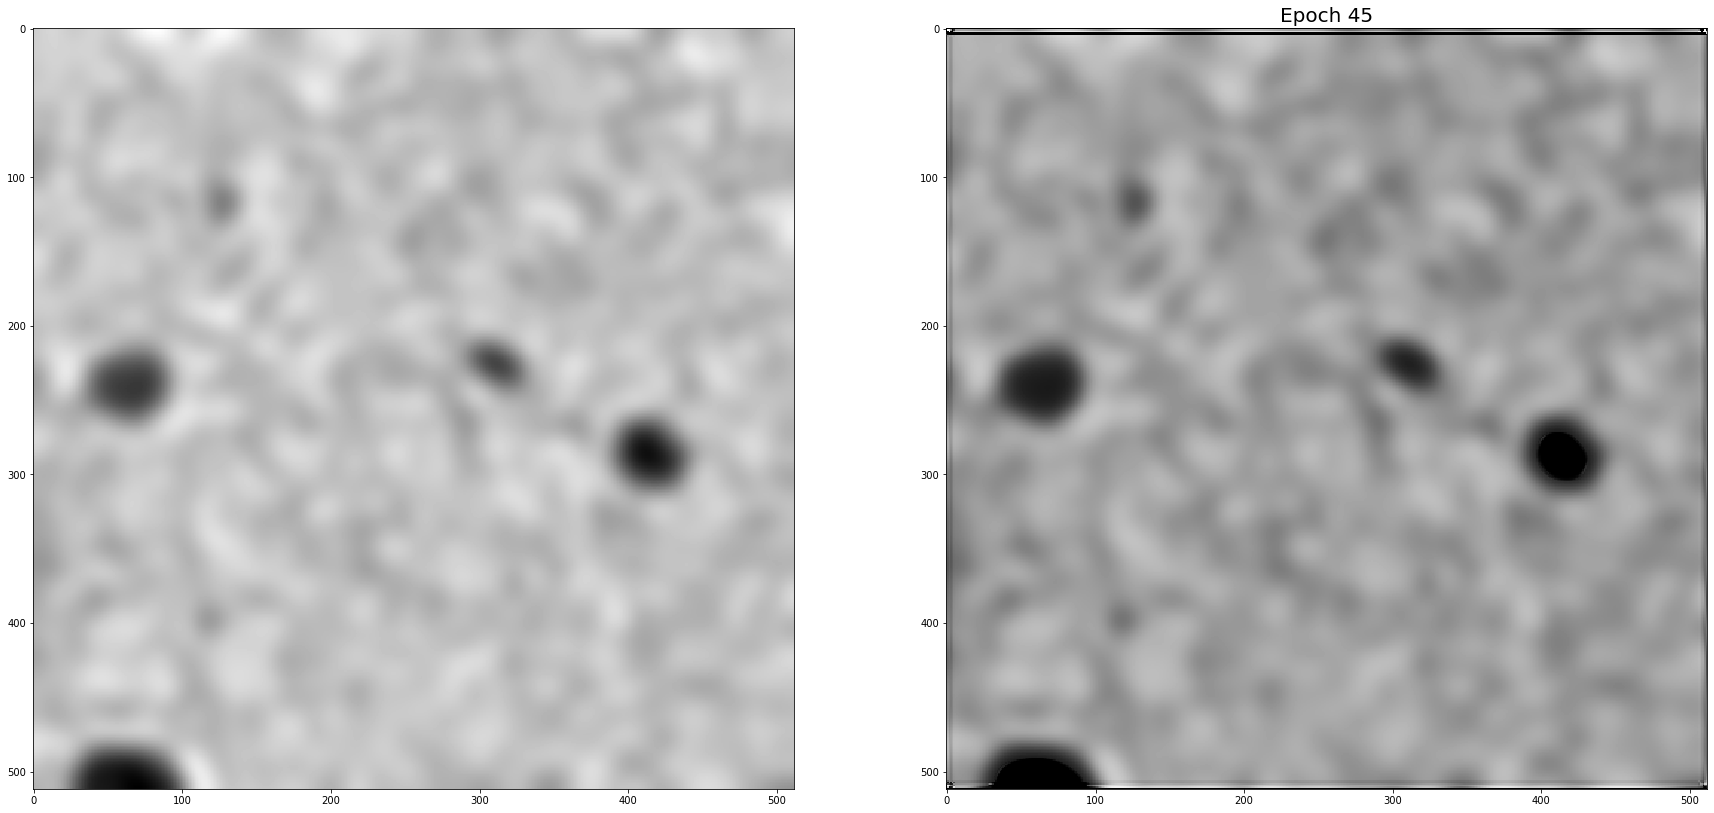

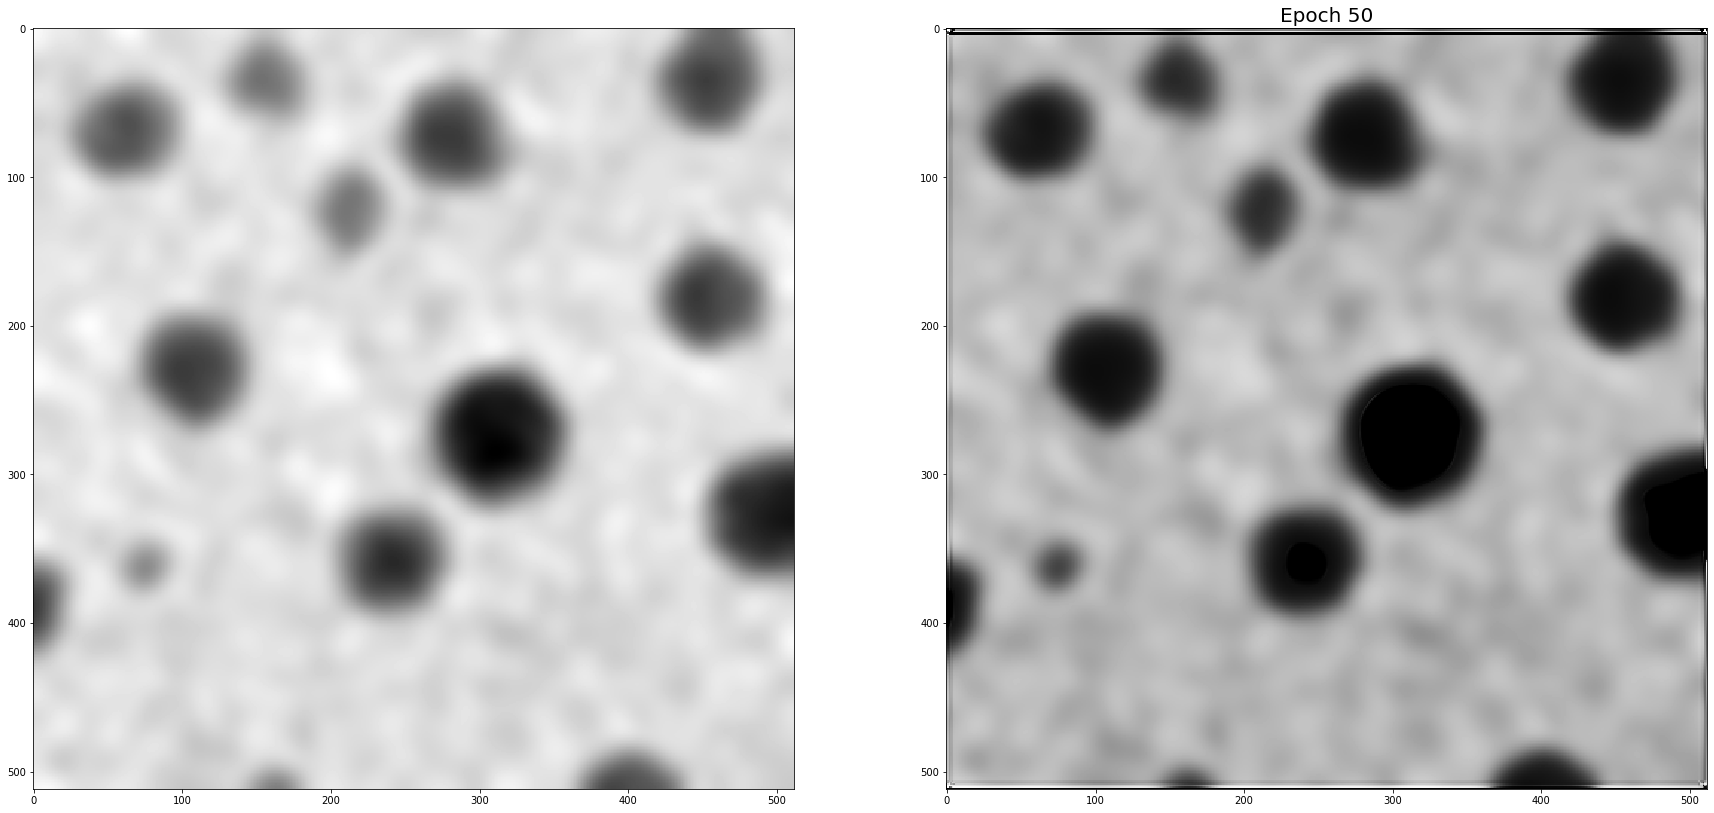

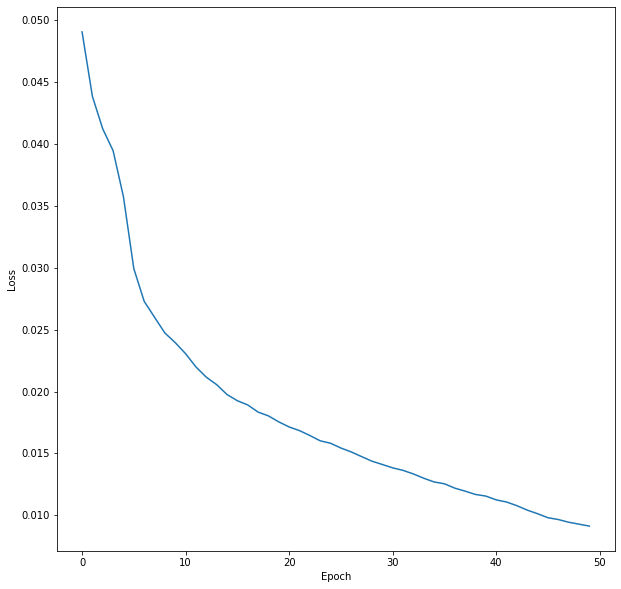

In [5]:
loss_history = []
start = time.time()
for epoch in range(50):

    start_epoch = time.time()
    print('Epoch {}'.format(epoch+1))
    running_loss = 0.0
    n = 0
    #scheduler.step()
    for i, data in enumerate(dataloader,0):
        inputs = data[0]
        inputs = inputs.to(device)
#        truth = truth.to(device)
#        print(inputs.size())
      
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs,inputs)
        loss.backward()        
        optimizer.step()
        
        
        running_loss += loss.item()
        if i % (len(dataloader)/10) == 0:
            print('{}%'.format(n))
            n += 10


    
    
    if (epoch + 1) % 5 == 0:
        f,a = plt.subplots(ncols=2,figsize=(30,20))
        im = inputs.detach().cpu().numpy()[0,0,:,:]
        out = outputs.detach().cpu().numpy()[0,0,:,:]
        a[0].imshow(im,plt.cm.gray)
        a[1].imshow(out,plt.cm.gray)
        a[1].set_title('Epoch {}'.format(epoch+1),fontsize=20)
        f.savefig(save_name+'_e{}.jpg'.format(epoch+1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        },save_name+'_e{}.pt'.format(epoch+1))
        
        
    print('loss: {}'.format(running_loss/len(dataloader)))
    print('Epoch time: {}\n'.format(time.time() - start_epoch))
    loss_history.append(running_loss/len(dataloader))
#    if (running_loss/len(dataloader)) < 1:
#        break
        
print('Finished Training')
print('Total Time: {}'.format(time.time() - start))


### Plot loss vs epoch
f,a = plt.subplots(figsize=(10,10)) 
a.set_xlabel('Epoch') 
a.set_ylabel('Loss') 
#a.set_title('UNet 04032019') 
a.plot(range(len(loss_history)),loss_history) 
f.savefig(save_name+'_Loss100.jpg')


In [ ]:
outputs.shape

In [ ]:
f,a = plt.subplots(ncols=2,figsize=(30,20))
a[0].imshow(im,plt.cm.gray)
#a[0].imshow(out,plt.cm.jet,alpha=0.4)
a[1].imshow(im,plt.cm.gray)
a[1].imshow(out,plt.cm.jet,alpha=0.4)
print(filters.threshold_otsu(out))
#f.savefig('/home/jay/data/autoencoder/LargeKernel/LRStep_30/thresholded.jpg')

In [6]:
test = np.load('training_set.npy',mmap_mode='r+')[12000:13000]

for i in range(len(test)):
    test[i] = filters.gaussian(test[i],sigma=3)
    
test = torch.Tensor(test.reshape(-1,1,512,512))
test_out = model(test)
print(test_out.shape)

test = test.detach().cpu().numpy()
test_out = test_out.detach().cpu().numpy()

torch.Size([1000, 1, 512, 512])


0.24109262 0.62372327
0.00033637523 1.0


(array([4.47300e+03, 1.57110e+04, 9.19200e+03, 7.60500e+04, 1.30731e+05,
        2.31360e+04, 1.30500e+03, 9.46000e+02, 5.61000e+02, 3.90000e+01]),
 array([3.3637523e-04, 1.0030274e-01, 2.0026910e-01, 3.0023545e-01,
        4.0020183e-01, 5.0016820e-01, 6.0013455e-01, 7.0010090e-01,
        8.0006725e-01, 9.0003365e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

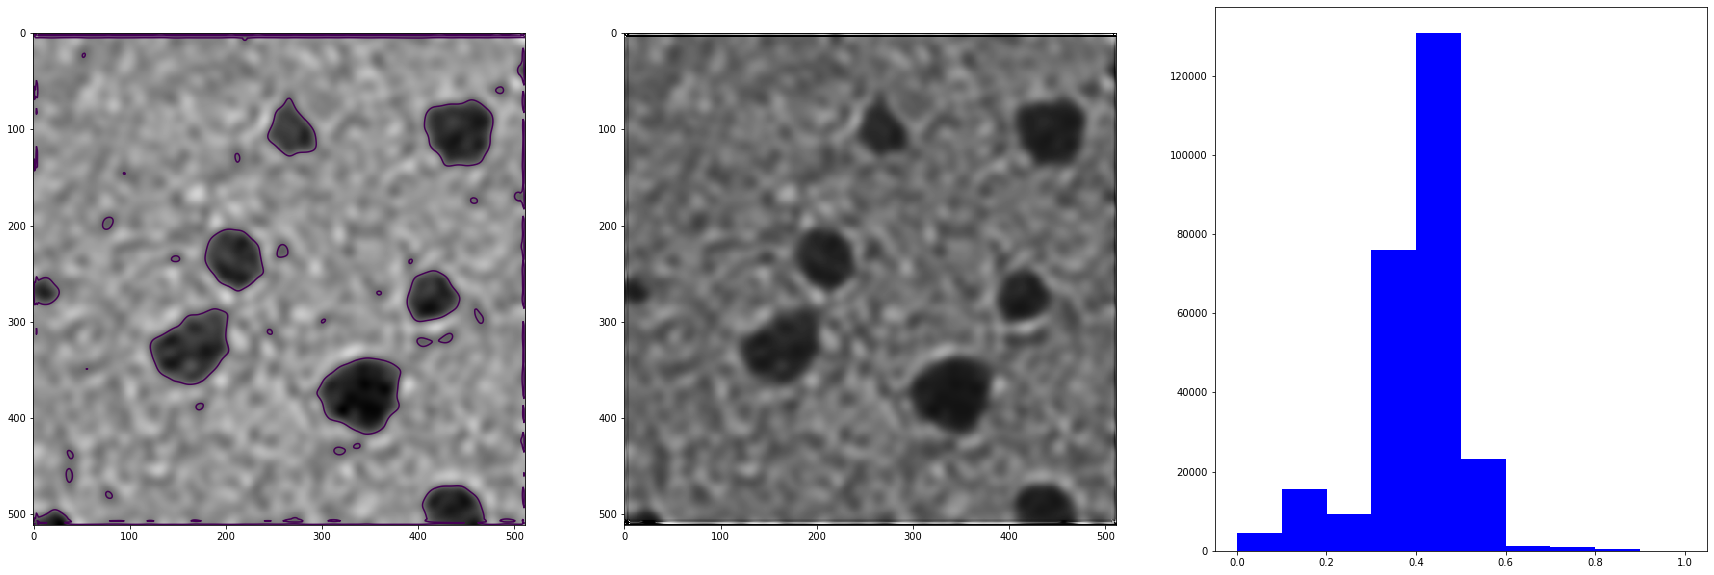

In [15]:
n = int(np.random.rand()*len(test_out))
print(np.min(test[n]),np.max(test[n]))
print(np.min(test_out[n]),np.max(test_out[n]))
f,a = plt.subplots(figsize=(30,10),ncols=3)
a[0].imshow(test[n].reshape(512,512),plt.cm.gray)
a[0].contour(test_out[n].reshape(512,512),[filters.threshold_otsu(test_out[n])])
a[1].imshow(test_out[n].reshape(512,512),plt.cm.gray)
a[2].hist(test_out[n].reshape(512*512),color='blue')

In [ ]:
f,a = plt.subplots(figsize=(10,10))
a.hist(im.reshape(1024*1024),color='blue',label='original')
a.hist(out.reshape(1024*1024),color='red',alpha=0.5,label='autoencoder')
a.set_xlabel('Intensity',fontsize=20)
a.set_ylabel('Frequency',fontsize=20)
a.legend(fontsize=15)
f.savefig('/home/jay/data/autoencoder/LargeKernel/LRStep_30/intensity_histogram.jpg')

In [ ]:
block_size = 101
f,a = plt.subplots(ncols=2,figsize=(30,20))
a[0].imshow(im,plt.cm.gray)
a[0].imshow(out < filters.threshold_local(out,block_size),plt.cm.jet,alpha=0.4)
a[1].hist(im.reshape(1024*1024),color='blue',label='original')
a[1].hist(out.reshape(1024*1024),color='red',alpha=0.5,label='autoencoder')
#a[1].vlines([filters.threshold_local(out,block_size)],ymin=0,ymax=450000)
print(filters.threshold_minimum(out))

### Inference routine

In [ ]:
start = time.time()
predictions = np.zeros((len(dataset),1,1024,1024))
batch_size=16
n = 0

for i, data in enumerate(dataloader,0):
    print(i)
    print('n: ',n*batch_size)
    inputs = data[0]
    print('in: ',inputs.shape)
    p = model(inputs.cuda())  ## Raw activations
    #p_soft = F.softmax(model(inputs.cuda()))  ## Applying final softmax layer
    p = p.detach().cpu().numpy()
    predictions[n*batch_size:n*batch_size+len(inputs),:,:,:] = p
    n += 1 
    
print(time.time() - start)
#p = predictions.detach().cpu().numpy()
np.save('/home/jay/data/autoencoder/LargeKernel/LRStep_30/all_first_seconds.npy',predictions.reshape(len(predictions),1024,1024))

In [ ]:
plt.imshow(predictions[-1,0])

### Visualize results by overlaying inference on raw image

In [ ]:
n = int(np.random.rand()*len(images))
f,a = plt.subplots(ncols=2,figsize=(30,20))
a[0].imshow(images[n,:,:],plt.cm.gray)
a[0].imshow(p_raw[n,1,:,:],plt.cm.jet,alpha=0.3)
a[1].imshow(images[n,:,:],plt.cm.gray)
a[1].imshow(p_soft[n,1,:,:] > 0.7,plt.cm.jet,alpha=0.3)

### Try connected components labelling

In [ ]:
lab = out < filters.threshold_otsu(out)
plt.subplots(figsize=(10,10))
plt.imshow(lab,plt.cm.gray)

In [ ]:
out_vec = out.reshape(1024*1024)

out_v = np.zeros((out_vec.shape[0],2))
for i in range(len(out_v)):
    out_v[i] = [i,out_vec[i]]

In [ ]:
plt.subplots(figsize=(20,20))
plt.scatter(out_v[:,0],out_v[:,1])

In [ ]:
filters.threshold_otsu(out)

In [ ]:
plt.subplots(figsize=(20,20))
plt.imshow(im < filters.threshold_otsu(im))
print(filters.threshold_otsu(im))